<a href="https://colab.research.google.com/github/fmomin01/Quora_Question-Pair-Similarity/blob/master/Quora_Question_Pair_Similarity_IPYNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quora Question Pairs Similarity

## 1. Business Problem

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

## Problem Statement 



*   Identify which questions asked on Quora are duplicates of questions that  
    have already been asked.

*   This could be useful to instantly provide answers to questions that have already been answered.

 

*   We are tasked with predicting whether a pair of questions are duplicates or not.

### Data Overview

- Data will be in a file Train.csv
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
- Size of Train.csv - 60MB
- Number of rows in Train.csv = 404,290

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
import sys
import os 
from tqdm import tqdm
import spacy

In [ ]:
import zipfile

zf = zipfile.ZipFile('../input/quora-question-pairs/train.csv.zip')
quora_df = pd.read_csv(zf.open('train.csv'))

In [ ]:
quora_df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [ ]:
quora_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


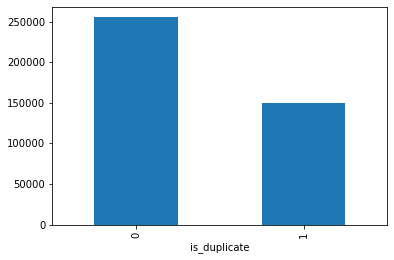

In [ ]:
quora_df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
quora_df['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [ ]:
print('Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(quora_df['is_duplicate'].mean()*100, 2)))
print('Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(quora_df['is_duplicate'].mean()*100, 2)))

Question pairs are not Similar (is_duplicate = 0):
   63.08%
Question pairs are Similar (is_duplicate = 1):
   36.92%


In [ ]:
question_ids=pd.Series(quora_df['qid1'].tolist() + quora_df['qid2'].tolist())

unique_questions=len(np.unique(question_ids))
questions_morethan1=np.sum(question_ids.value_counts() > 1)


print('Total No of Unique questions :{} \n'.format(unique_questions))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(questions_morethan1,questions_morethan1/unique_questions*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(question_ids.value_counts()))) 

q_vals=question_ids.value_counts()

q_vals=q_vals.values

Total No of Unique questions :537933 

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



In [ ]:
type(question_ids)

pandas.core.series.Series

In [ ]:
question_ids[:5]

0    1
1    3
2    5
3    7
4    9
dtype: int64

In [ ]:
nan_rows=quora_df[quora_df.isnull().any(1)]

print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [ ]:
quora_df=quora_df.fillna('')

nan_rows=quora_df[quora_df.isnull().any(1)]

print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 3.3 Basic Feature Extraction (before cleaning)



1.   freq_qid1 = Frequency of qid1's
2.   freq_qid2 = Frequency of qid2's
3.   q1len = Length of q1
4.   q2len = Length of q2
5.   q1_n_words = Number of words in Question 1
6.   q2_n_words = Number of words in Question 2
7.   word_Common = (Number of common unique words in Question 1 and Question 2)
8.   word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
9.   word_share = (word_common)/(word_Total)
10.  freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
11.  freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [ ]:
if os.path.isfile('feature_engg_preprocessing_train.csv'):
  quora_df = pd.read_csv("feature_engg_preprocessing_train",encoding='latin-1')
else:

  quora_df['freq_qid1'] = quora_df.groupby('qid1')['qid1'].transform('count')
  quora_df['freq_qid2'] = quora_df.groupby('qid2')['qid2'].transform('count')
  quora_df['q1len'] = quora_df['question1'].str.len()
  quora_df['q2len'] = quora_df['question2'].str.len()
  quora_df['q1_n_words'] = quora_df['question1'].apply(lambda row: len(row.split(" ")))
  quora_df['q2_n_words'] = quora_df['question2'].apply(lambda row: len(row.split(" ")))

  def normalized_word_Common(row):
     w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
     w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
     return 1.0 * len(w1 & w2)
  quora_df['word_Common'] = quora_df.apply(normalized_word_Common, axis=1)

  def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
  quora_df['word_Total'] = quora_df.apply(normalized_word_Total, axis=1)

  def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
  quora_df['word_share'] = quora_df.apply(normalized_word_share, axis=1)

  quora_df['freq_q1+q2'] = quora_df['freq_qid1']+quora_df['freq_qid2']
  quora_df['freq_q1-q2'] = abs(quora_df['freq_qid1']-quora_df['freq_qid2'])

  quora_df.to_csv("feature_engg_preprocessing_train.csv", index=False)

quora_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [ ]:
print ("Minimum length of the questions in question1 : " , min(quora_df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(quora_df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", quora_df[quora_df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", quora_df[quora_df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


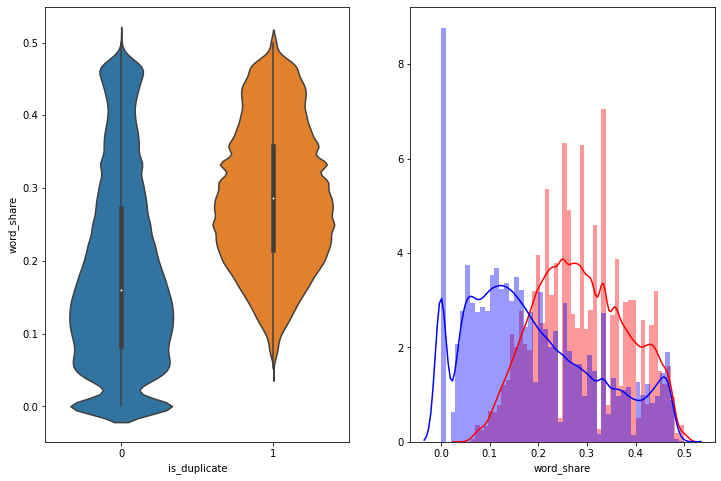

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = quora_df[0:])

plt.subplot(1,2,2)
sns.distplot(quora_df[quora_df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(quora_df[quora_df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

### By looking at the Violenplot , below are the 2 observations :

1. The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
2. The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

In [ ]:
pip install fuzzywuzzy

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
if os.path.isfile('feature_engg_preprocessing_train.csv'):
    quora_df = pd.read_csv("feature_engg_preprocessing_train.csv",encoding='latin-1')
    quora_df = quora_df.fillna('')
    quora_df.head()
else:
    print("get feature_engg_preprocessing_train.csv from drive or run the previous notebook")

In [ ]:
quora_df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset       
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
pip install distance

     |████████████████████████████████| 180 kB 188 kB/s eta 0:00:01
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16261 sha256=c4baae669715b9fe4dcf31154a96776cd7d74680a74c00e5d5613bb95f6b46ef
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import distance
if os.path.isfile('nlp_features_train.csv'):
    quora_df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    quora_df.fillna('')
else:
    print("Extracting features for train:")
    quora_df = pd.read_csv('../input/quora-question-pairs/train.csv.zip')
    quora_df = extract_features(quora_df)
    quora_df.to_csv("nlp_features_train.csv", index=False)
quora_df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


## GENERATING WORD CLOUD OF DUPLICATES AND NON DUPLICATE QUESTION PAIRS. WE CAN OBSERVE MOST FREQUENT OCCURING WORDS

In [ ]:
df_duplicate = quora_df[quora_df['is_duplicate'] == 1]
df_nonduplicate = quora_df[quora_df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [ ]:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
stopwords.remove("like")

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


Word Cloud for Duplicate Question pairs


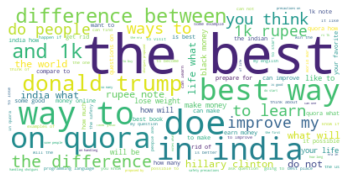

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


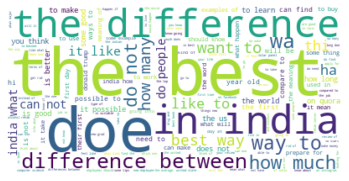

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## TAKE 100K DATAPOINTS AND SPLIT THEM INTO INTO TEST AND TRAIN 

## FEATURIZING TEXT DATA USING TF-IDF 

In [ ]:
quora_df['question1']=quora_df['question1'].apply(lambda x:str(x))
quora_df['question2']=quora_df['question2'].apply(lambda x:str(x))

quora_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [ ]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('feature_engg_preprocessing_train.csv'):
    dfppro = pd.read_csv("feature_engg_preprocessing_train.csv",encoding='latin-1')
else:
    print("download ./feature_engg_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [ ]:
df3=dfnlp[['id','question1','question2']]
duplicate=dfnlp.is_duplicate

In [ ]:
df3 = df3.fillna(' ')

In [ ]:
new_dataframe = pd.DataFrame()

new_dataframe['questions']=df3.question1 + ' ' + df3.question2
new_dataframe['id']=df3.id
df2['id']=df1['id']
new_dataframe['id']=df1['id']
final_df = df1.merge(df2, on='id',how='left')
X_Final  = final_df.merge(new_dataframe, on='id',how='left')

In [ ]:
X_Final=X_Final.drop('id',axis=1)

In [ ]:
X_Final.shape

(404290, 27)

In [ ]:
X_Final.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,questions
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,66,57,14,12,10.0,23.0,0.434783,2,0,what is the step by step guide to invest in sh...
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,51,88,8,13,4.0,20.0,0.200000,5,3,what is the story of kohinoor koh i noor dia...


In [ ]:
X_Final.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'questions'],
      dtype='object')

In [ ]:
X_Final.shape

(404290, 27)

In [ ]:
Y_Final=np.array(duplicate)

In [ ]:
X_Final_100K = X_Final[0:100000]
Y_Final_100K = Y_Final[0:100000]

In [ ]:
X_Train,X_Test,Y_Train,Y_Test = train_test_split(X_Final_100K,Y_Final_100K,test_size=0.2,random_state=0)

In [ ]:
print(X_Train.shape)
print(X_Test.shape)
print(Y_Train.shape)
print(Y_Test.shape)


(80000, 27)
(20000, 27)
(80000,)
(20000,)


In [ ]:
X_train_ques=X_Train['questions']
X_test_ques=X_Test['questions']

X_Train=X_Train.drop('questions',axis=1)
X_Test=X_Test.drop('questions',axis=1)

## FEATURIZATION DATA USING TF-IDF WEIGHTED WORD2VEC

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vector=TfidfVectorizer(lowercase=False)
tfidf_vector.fit_transform(X_train_ques)

word2Vectfidf = dict(zip(tfidf_vector.get_feature_names(), tfidf_vector.idf_))

In [ ]:
pip install spacy

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
nlp = spacy.load('en_core_web_sm')

vecs1 = []

for qu1 in tqdm(list(X_train_ques)):
    doc1 = nlp(qu1)    

100%|██████████| 80000/80000 [15:45<00:00, 84.61it/s]


In [ ]:
type(doc1)

spacy.tokens.doc.Doc

In [ ]:
len(doc1)

27

In [ ]:
doc1[0].vector

array([ 1.0538651 , -1.5820868 ,  3.4776258 ,  0.935477  ,  3.6865556 ,
        2.6442935 , -1.295749  ,  3.5730176 ,  0.58064187,  4.5647173 ,
       -1.2372794 , -2.1921372 ,  2.5050468 , -1.6756942 ,  0.5850357 ,
        1.9769262 ,  0.3176741 , -0.55816364, -1.4117941 , -0.5193449 ,
       -0.5428067 , -2.0756364 , -1.6847615 , -0.43306267, -0.4624439 ,
        5.127439  , -0.74940324, -2.5899384 , -1.6161432 ,  3.268897  ,
       -1.2635069 , -0.618773  ,  2.6072092 ,  3.0338886 ,  4.200698  ,
       -0.96053797, -0.24093892, -0.30276054, -0.267563  , -1.4786704 ,
       -1.4116931 ,  1.5478495 ,  2.4584115 ,  1.1284287 ,  0.09499019,
       -0.45830882,  0.10724139, -2.9898572 , -2.675263  , -1.06363   ,
        0.07585567,  3.1413882 , -0.3426143 ,  5.117551  , -0.51212335,
       -1.4873524 ,  2.910406  ,  1.3965878 , -1.7634395 , -4.233181  ,
        0.03840446, -3.8031409 , -3.183027  ,  1.2468984 , -3.3134398 ,
        0.31199908,  0.19682753, -4.5600977 ,  1.9287844 , -0.72

In [ ]:
len(doc1[0].vector)

96

In [ ]:
nlp = spacy.load('en_core_web_sm')

vecs1 = []

for qu1 in tqdm(X_train_ques):
    #doc1 = nlp(qu1)      
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2Vectfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
#X_train_ques['q1_feats_m'] = list(vecs1)

100%|██████████| 80000/80000 [00:32<00:00, 2456.71it/s]


In [ ]:
for qu2 in tqdm(list(X_test_ques)):    
    doc2 = nlp(qu2) 

100%|██████████| 20000/20000 [04:00<00:00, 83.00it/s]


In [ ]:
type(doc2)

spacy.tokens.doc.Doc

In [ ]:
len(doc2)

19

In [ ]:
doc2[0].vector

array([ 1.0071449 , -2.1742587 ,  3.1489015 , -0.18410909,  3.128718  ,
        2.458135  , -2.2570815 ,  2.3861847 , -3.0271459 ,  5.943254  ,
        1.9911594 , -0.6527443 , -0.7036731 , -2.704289  , -1.7651609 ,
        0.5286171 ,  3.0766854 , -0.736804  , -5.2804403 ,  0.41588047,
       -1.924056  , -1.7303743 , -1.5512371 ,  0.5014181 , -2.0359368 ,
        3.5808473 , -1.3536528 ,  0.09200308, -1.1890454 ,  1.5964959 ,
       -3.571322  ,  0.41140145,  1.8229793 ,  2.088276  ,  0.31387448,
       -1.8878491 , -0.64605516, -1.8430301 , -2.6838398 , -1.1270303 ,
       -1.2592908 ,  2.9189396 ,  1.8792181 ,  1.9031954 ,  1.5901439 ,
        2.6293778 ,  1.145259  , -2.5737615 , -0.69571686, -2.1545959 ,
        0.5274311 ,  1.5168011 ,  0.5444969 ,  3.6052732 ,  2.5105577 ,
        0.722912  ,  0.47371024,  2.0868702 ,  1.2551434 , -2.9224956 ,
       -1.1268238 , -3.1648865 , -3.4425666 , -0.8653979 , -4.620832  ,
        1.2002788 , -2.3373365 , -3.257043  ,  3.2764444 , -0.49

In [ ]:
len(doc2[0].vector)

96

In [ ]:
vecs2 = []

for qu2 in tqdm(list(X_test_ques)):
    #doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:        
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2Vectfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
#X_Test['q2_feats_m'] = list(vecs2)

100%|██████████| 20000/20000 [00:05<00:00, 3548.63it/s]


In [ ]:
train_df=pd.DataFrame(vecs1)
test_df = pd.DataFrame(vecs2)

In [ ]:
X_Train.head(5)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
10382,0.999950,0.666644,0.999975,0.799984,0.857131,0.857131,0.0,1.0,0.0,7.0,...,1,32,40,7,7,6.0,14.0,0.428571,2,0
73171,0.999975,0.999975,0.999975,0.799984,0.999988,0.888879,1.0,0.0,1.0,8.5,...,1,41,37,9,8,8.0,17.0,0.470588,2,0
30938,0.799984,0.799984,0.999975,0.999975,0.888879,0.888879,0.0,1.0,0.0,9.0,...,1,54,54,8,8,7.0,16.0,0.437500,6,4
99310,0.000000,0.000000,0.799984,0.499994,0.235293,0.199999,0.0,0.0,3.0,18.5,...,1,116,105,20,17,4.0,34.0,0.117647,3,1
58959,0.749981,0.749981,0.999975,0.999975,0.874989,0.874989,1.0,1.0,0.0,8.0,...,9,42,49,8,8,7.0,16.0,0.437500,11,7


In [ ]:
X_Train.values

array([[0.99995   , 0.66664445, 0.999975  , ..., 0.42857143, 2.        ,
        0.        ],
       [0.999975  , 0.999975  , 0.999975  , ..., 0.47058824, 2.        ,
        0.        ],
       [0.799984  , 0.799984  , 0.999975  , ..., 0.4375    , 6.        ,
        4.        ],
       ...,
       [0.77776914, 0.77776914, 0.99996667, ..., 0.4       , 2.        ,
        0.        ],
       [0.4999875 , 0.399992  , 0.799984  , ..., 0.22222222, 2.        ,
        0.        ],
       [0.4999875 , 0.4999875 , 0.66665556, ..., 0.20833333, 2.        ,
        0.        ]])

In [ ]:
train_df.head(4)

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-28.879126,96.972658,57.716938,-50.641853,65.582543,1.314806,88.495749,-33.27594,71.503786,211.29342,...,-14.42054,1.575778,-64.026994,31.487257,-17.921669,-22.530325,-125.776964,73.217936,50.80376,-7.673488
1,-28.879126,96.972658,57.716938,-50.641853,65.582543,1.314806,88.495749,-33.27594,71.503786,211.29342,...,-14.42054,1.575778,-64.026994,31.487257,-17.921669,-22.530325,-125.776964,73.217936,50.80376,-7.673488
2,-28.879126,96.972658,57.716938,-50.641853,65.582543,1.314806,88.495749,-33.27594,71.503786,211.29342,...,-14.42054,1.575778,-64.026994,31.487257,-17.921669,-22.530325,-125.776964,73.217936,50.80376,-7.673488
3,-28.879126,96.972658,57.716938,-50.641853,65.582543,1.314806,88.495749,-33.27594,71.503786,211.29342,...,-14.42054,1.575778,-64.026994,31.487257,-17.921669,-22.530325,-125.776964,73.217936,50.80376,-7.673488


In [ ]:
from scipy.sparse import hstack
X_Train = hstack((X_Train.values,train_df))
X_Test= hstack((X_Test.values,test_df))
print(X_Train.shape)
print(X_Test.shape)

(80000, 122)
(20000, 122)


In [ ]:
type(X_Train)

scipy.sparse.coo.coo_matrix

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### BUILDING A RANDOM MODEL AND FINDING THE WORST CASE LOG LOSS

In [ ]:
test_len = len(Y_Test)

Log loss on Test Data using Random Model 0.8807067666261346


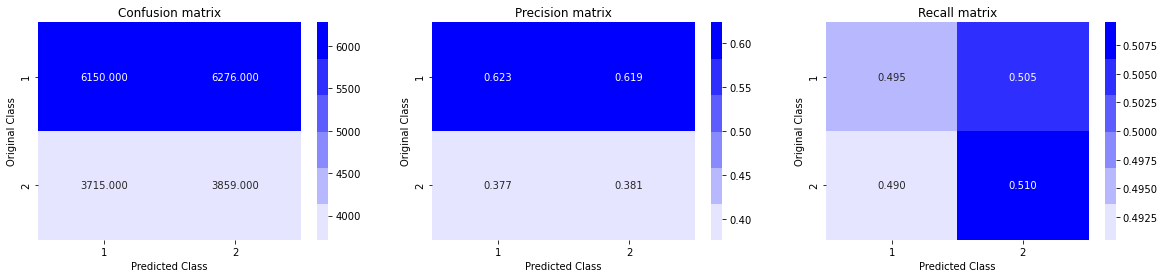

In [ ]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(Y_Test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(Y_Test, predicted_y)

### LOGISTIC REGRESSION TO FIND HYPERPARAMETER

For values of alpha =  1e-05 The log loss is: 1.2453694155535802
For values of alpha =  0.0001 The log loss is: 0.9920071022015416
For values of alpha =  0.001 The log loss is: 0.9163418523541846
For values of alpha =  0.01 The log loss is: 1.2418470551956216
For values of alpha =  0.1 The log loss is: 1.0370693635329
For values of alpha =  1 The log loss is: 1.0747495085533938
For values of alpha =  10 The log loss is: 1.0430758885512146


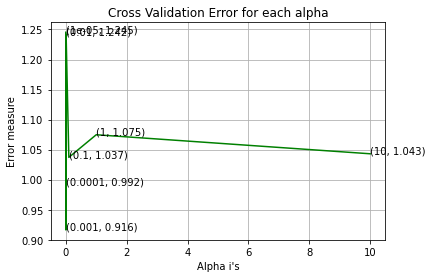

For values of best alpha =  0.001 The train log loss is: 0.4314372963865273
For values of best alpha =  0.001 The test log loss is: 0.9163418523541846
Total number of data points : 20000


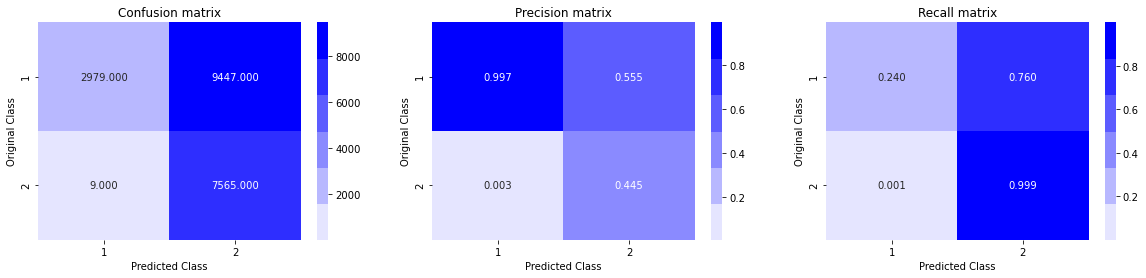

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_Train, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train, Y_Train)
    predict_y = sig_clf.predict_proba(X_Test)
    log_error_array.append(log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_Train, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train, Y_Train)

predict_y = sig_clf.predict_proba(X_Train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_Test, predicted_y)

### LINEAR SVM WITH HYPERPARAMETER TUNING 

For values of alpha =  1e-05 The log loss is: 0.6635502766464555
For values of alpha =  0.0001 The log loss is: 0.6635502766464555
For values of alpha =  0.001 The log loss is: 0.5457645428564535
For values of alpha =  0.01 The log loss is: 0.5452993529404698
For values of alpha =  0.1 The log loss is: 0.5377513378944977
For values of alpha =  1 The log loss is: 0.6516044222566405
For values of alpha =  10 The log loss is: 0.6544381270044712


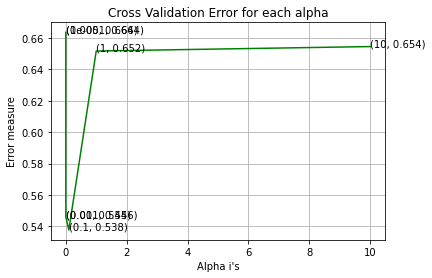

For values of best alpha =  0.1 The train log loss is: 0.5209752598067761
For values of best alpha =  0.1 The test log loss is: 0.5377513378944977
Total number of data points : 20000


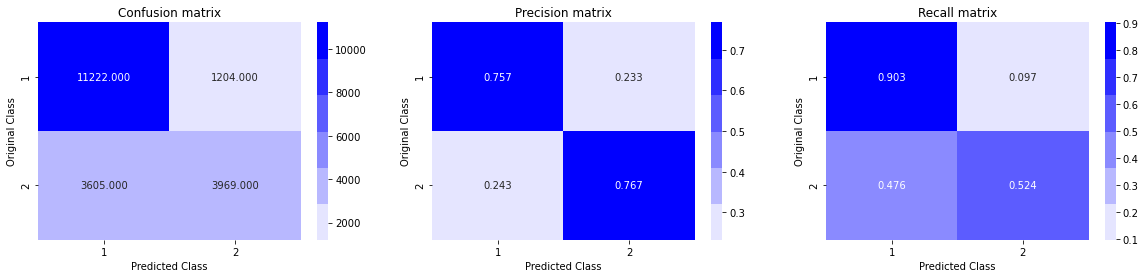

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_Train, Y_Train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_Train, Y_Train)
    predict_y = sig_clf.predict_proba(X_Test)
    log_error_array.append(log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_Train, Y_Train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_Train, Y_Train)

predict_y = sig_clf.predict_proba(X_Train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_Train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_Test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_Test, predicted_y)

### XGBoost

In [ ]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_Train, label=Y_Train)
d_test = xgb.DMatrix(X_Test, label=Y_Test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_Train,Y_Train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(Y_Test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.68483	valid-logloss:0.68485
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61627	valid-logloss:0.61574
[20]	train-logloss:0.56566	valid-logloss:0.56459
[30]	train-logloss:0.52765	valid-logloss:0.52614
[40]	train-logloss:0.49834	valid-logloss:0.49647
[50]	train-logloss:0.47574	valid-logloss:0.47371
[60]	train-logloss:0.45759	valid-logloss:0.45541
[70]	train-logloss:0.44292	valid-logloss:0.44057
[80]	train-logloss:0.43107	valid-logloss:0.42855
[90]	train-logloss:0.42141	valid-logloss:0.41866
[100]	train-logloss:0.41348	valid-logloss:0.41055
[110]	train-logloss:0.40669	valid-logloss:0.40364
[120]	train-logloss:0.40104	valid-logloss:0.39787
[130]	train-logloss:0.39617	valid-logloss:0.39291
[140]	train-logloss:0.39213	valid-logloss:0.38888
[150]	train-logloss:0.38867	valid-logloss:0.38540
[160]	train-logloss:0.38569	valid-logloss:0.38239
[170]	trai

Total number of data points : 20000


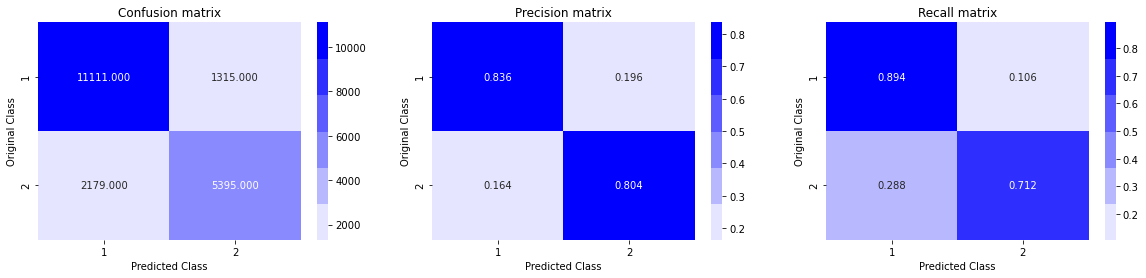

In [ ]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_Test, predicted_y)

### TF-IDF VECTORIZATION ON QUORA QUESTION PAIR SIMILARITY

In [ ]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('feature_engg_preprocessing_train.csv'):
    dfppro = pd.read_csv("feature_engg_preprocessing_train.csv",encoding='latin-1')
else:
    print("download ./feature_engg_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
X_Final.shape

(404290, 27)

In [ ]:
X_final_100K = X_Final[0:100000]
Y_final_100K = Y_Final[0:100000]

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X_final_100K,Y_final_100K,test_size=0.2,random_state=0)

In [ ]:
X_train_questions = X_train['questions']
X_test_questions = X_test['questions']

In [ ]:
X_train = X_train.drop('questions',axis=1)
X_test = X_test.drop('questions',axis=1)

In [ ]:
X_train.shape

(80000, 26)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector=TfidfVectorizer(ngram_range=(1,3),min_df=5)

X_train_data_tfidf= tfidf_vector.fit_transform(X_train_questions)
X_test_data_tfidf= tfidf_vector.transform(X_test_questions)

In [ ]:
X_train = hstack((X_train.values,X_train_data_tfidf))
X_test= hstack((X_test.values,X_test_data_tfidf))
print(X_train.shape)
print(X_test.shape)

(80000, 77871)
(20000, 77871)


## Logistic Regression to find Hyperparameter

For values of alpha =  1e-05 The log loss is: 0.40326991119004296
For values of alpha =  0.0001 The log loss is: 0.40144393658653393
For values of alpha =  0.001 The log loss is: 0.41947690219516665
For values of alpha =  0.01 The log loss is: 0.44883125023089315
For values of alpha =  0.1 The log loss is: 0.4570594984462411
For values of alpha =  1 The log loss is: 0.4892626583614142
For values of alpha =  10 The log loss is: 0.5464328640076541


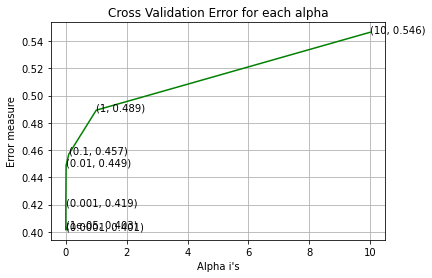

For values of best alpha =  0.0001 The train log loss is: 0.40341924489604986
For values of best alpha =  0.0001 The test log loss is: 0.40144393658653393
Total number of data points : 20000


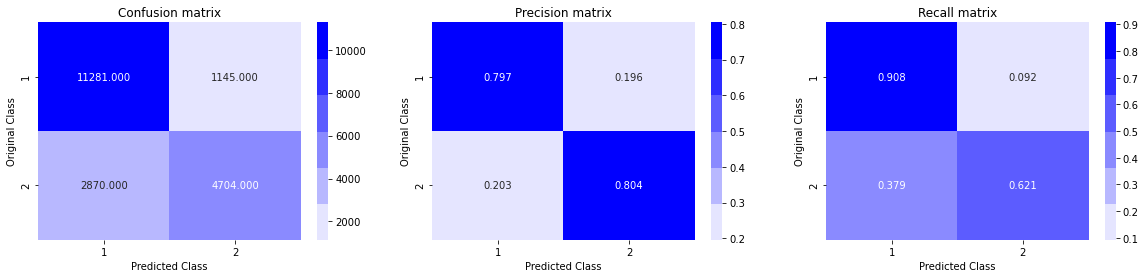

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, Y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, Y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Linear SVM

For values of alpha =  1e-05 The log loss is: 0.4329444709543552
For values of alpha =  0.0001 The log loss is: 0.46043580710570003
For values of alpha =  0.001 The log loss is: 0.4578957532496454
For values of alpha =  0.01 The log loss is: 0.48616746425160334
For values of alpha =  0.1 The log loss is: 0.5026315479394828
For values of alpha =  1 The log loss is: 0.5720472027391044
For values of alpha =  10 The log loss is: 0.6470287308834826


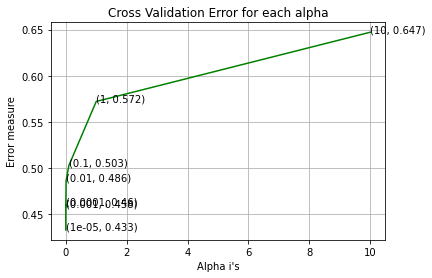

For values of best alpha =  1e-05 The train log loss is: 0.43367112833076243
For values of best alpha =  1e-05 The test log loss is: 0.4329444709543552
Total number of data points : 20000


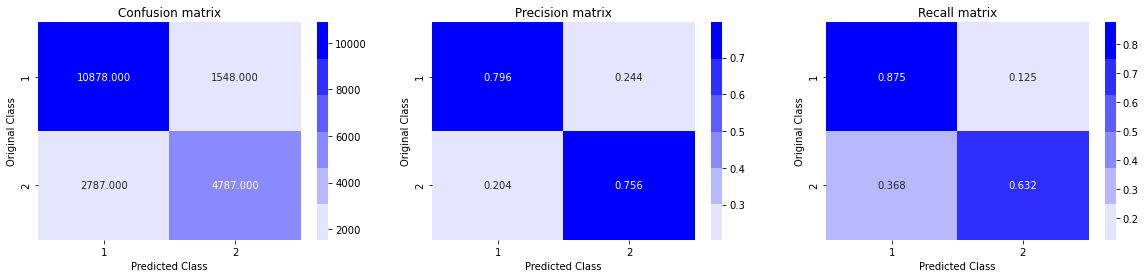

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, Y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, Y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

## Hyperparameter tuning using RandomSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

param = {"max_depth":[1,5,10,50,100,500,1000],"n_estimators":[20,40,60,80,100]}

xgb_classifier=xgb.XGBClassifier(n_jobs=-1,random_state=25)

model = RandomizedSearchCV(xgb_classifier,param,n_iter=30,scoring='neg_log_loss',cv=3,n_jobs=-1)

model.fit(X_train,Y_train)
model.best_params_

{'n_estimators': 100, 'max_depth': 10}

Train log loss =  0.21311021906374658  Test log loss =  0.31635752518498184


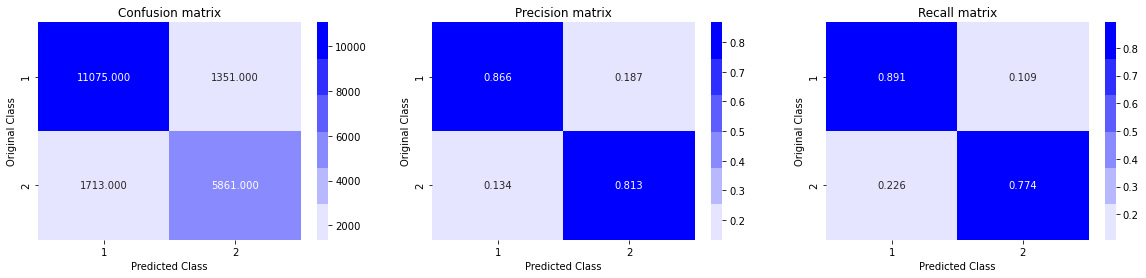

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=10,n_estimators=100)
clf.fit(X_train,Y_train)
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(Y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(Y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(Y_test,predicted_y)

## Pretty Table 

In [ ]:
pip install -U PTable

  Created wheel for PTable: filename=PTable-0.9.2-py3-none-any.whl size=22907 sha256=1a7d6de527963a5e01a7591beae5aaaac35df8f5be937d1ea7e4796658910e44
  Stored in directory: /root/.cache/pip/wheels/33/df/2f/674985b3f8a2de3f96357d1eadef5110f74fa91b3785e52a54
Successfully built PTable
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# DRAW CONCLUSION

In [ ]:
from prettytable import PrettyTable
x= PrettyTable()

x.field_names = ["VECTORIZER","TYPE OF MODEL","TRAIN LOG LOSS","TEST LOG LOSS"]
x.add_row(['TF-IDF WEIGHTED W2V','LOGISTIC REGRESSION(ALPHA=0.001)','0.4314','0.9163'])
x.add_row(['TF-IDF WEIGHTED W2V','LINEAR SVM(ALPHA = 0.1)','0.5209','0.5377'])
x.add_row(['TF-IDF WEIGHTED W2V','XGBOOST','0.3545','0.3532'])
x.add_row(['TF-IDF','LOGISTIC REGRESSION(ALPHA=0.0001)','0.4034 ','0.4014'])
x.add_row(['TF-IDF','LINEAR SVM(ALPHA=0.00001)','0.4336','0.4329'])
x.add_row(['TF-IDF','XGBOOST','0.2131 ','0.3163'])

print(x)

+---------------------+-----------------------------------+----------------+---------------+
|      VECTORIZER     |           TYPE OF MODEL           | TRAIN LOG LOSS | TEST LOG LOSS |
+---------------------+-----------------------------------+----------------+---------------+
| TF-IDF WEIGHTED W2V |  LOGISTIC REGRESSION(ALPHA=0.001) |     0.4314     |     0.9163    |
| TF-IDF WEIGHTED W2V |      LINEAR SVM(ALPHA = 0.1)      |     0.5209     |     0.5377    |
| TF-IDF WEIGHTED W2V |              XGBOOST              |     0.3545     |     0.3532    |
|        TF-IDF       | LOGISTIC REGRESSION(ALPHA=0.0001) |    0.4034      |     0.4014    |
|        TF-IDF       |     LINEAR SVM(ALPHA=0.00001)     |     0.4336     |     0.4329    |
|        TF-IDF       |              XGBOOST              |    0.2131      |     0.3163    |
+---------------------+-----------------------------------+----------------+---------------+


### LOOKING AT THE PRETTY TABLE , THE TF-IDF VECTORIZER USING XG-BOOST PERFORM WELL WITH LESS TRAIN LOSS = 0.2131 AND TEST LOSS = 0.3163